In [1]:
!pip3 install --quiet tensorflow-gpu==1.13.1
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet tf-sentencepiece
!pip install tensorboardcolab

import tensorflow as tf
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

import os, sys, datetime
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir)
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

import tf_sentencepiece
#import training.train as t
from data import load_dataset
from tqdm import tqdm_notebook as tqdm

Version:  1.13.1
Eager mode:  False
GPU is available
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.git', 'README.md', 'data', 'presentations', '.idea', 'training', 'blobs', '.gitignore', 'template.py', '.ipynb_checkpoints', 'report.ipynb', 'serverblobs']


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tf_sentencepiece

from data import load_dataset
from data import confusion
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import glob, time, datetime, os, pickle
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, classification_report

class Model:
    def __init__(self, data_X, data_Y, n_classes, params):
        self.params = params
        self.n_class = n_classes
        self.architecture = params["architecture"][1:]
        #print("Downloading xling...")
        self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=params["architecture"][0])
        self.data_X = data_X
        self.data_Y = data_Y
        self.create_architecture(data_X, data_Y)

    def create_architecture(self, data_X, data_Y):
        # y_hot = tf.one_hot(data_Y, depth=self.n_class)
        
        
        embeddings = self.xling(data_X)
        self.hidden = tf.layers.dense(embeddings, 150, name="my_hidden_dense")
        output = tf.layers.dense(self.hidden, self.n_class, name="final_output_prediction")
        
        self.relevance = tf.layers.dense(self.hidden, 2, name="head_relevance")
        self.attribute = tf.layers.dense(self.hidden, 14, name="head_attribute")
        self.entity = tf.layers.dense(self.hidden, 9, name="head_entity")
        
        
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=output))
        self.train_op = self.params["optimizer"].minimize(self.loss)
        self.predictions = tf.argmax(output, 1)
        self.labels = data_Y
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32))
        
        
        self.relevance_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.relevance))
        self.relevance_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.relevance_loss)
        self.relevance_predictions = tf.argmax(self.relevance, 1)
        self.relevance_accuracy = tf.reduce_mean(tf.cast(tf.equal(self.relevance_predictions, tf.cast(data_Y, tf.int64)), tf.float32))
        
        self.attribute_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.attribute))
        self.attribute_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.attribute_loss)
        self.attribute_predictions = tf.argmax(self.attribute, 1)
        self.attribute_accuracy = tf.reduce_mean(tf.cast(tf.equal(self.attribute_predictions, tf.cast(data_Y, tf.int64)), tf.float32))
        
        self.entity_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.entity))
        self.entity_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.entity_loss)
        self.entity_predictions = tf.argmax(self.entity, 1)
        self.entity_accuracy = tf.reduce_mean(tf.cast(tf.equal(self.entity_predictions, tf.cast(data_Y, tf.int64)), tf.float32))


        


In [9]:
def trainModel(p):
    # init default params
    params = {}
    #params["trainData"] = "US"
    #params["testData"] = "DE"
    params["epochs"] = 15
    params["batchSize"] = 512
    params["optimizer"] = tf.train.AdamOptimizer(learning_rate=0.001)
    params["trainexamples"] = 1000 * 100
    #params["architecture"] = [False]
    params["f1modus"] = "micro"
    params["savelog"] = True
    params["checkpoint"] = True
    params["path"] = "blobs/" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
    params["pathToCache"] = "data/"
    params["notebook"] = False
    params["showPlots"] = False
    params["includeReviewHeadline"] = False
    params["filterOtherLanguages"] = False
    params["regularization"] = False

    params.update(p)  # overwrite default parameter with passed parameter
    params["learning_rate"] = params["optimizer"]._lr

    if params["notebook"] == True:
        from tqdm import tqdm_notebook as tqdm
    else:
        from tqdm import tqdm as tqdm


    tf.reset_default_graph()
    dataset_train, num_classes = load_dataset.getData(params["trainData"], shuffle=True, batchsize=params["batchSize"], pathToCache=params["pathToCache"], includeHeading=params["includeReviewHeadline"],maxrows=params["trainexamples"], filterOtherLangs=params["filterOtherLanguages"])
    dataset_val, num_classes2 = load_dataset.getData(params["testData"], shuffle=False, batchsize=params["batchSize"], pathToCache=params["pathToCache"], includeHeading=params["includeReviewHeadline"],maxrows=params["trainexamples"], filterOtherLangs=params["filterOtherLanguages"])
    
    dataset_train_relevance, _ = load_dataset.getData("organic_train_relevance", shuffle=True, batchsize=256, pathToCache="data/")
    dataset_val_relevance, _ = load_dataset.getData("organic_test_relevance", shuffle=False, batchsize=256, pathToCache="data/")
    
    dataset_train_attribute, _ = load_dataset.getData("organic_train_attribute", shuffle=True, batchsize=256, pathToCache="data/")
    dataset_val_attribute, _ = load_dataset.getData("organic_test_attribute", shuffle=False, batchsize=256, pathToCache="data/")
    
    dataset_train_entity, _ = load_dataset.getData("organic_train_entity", shuffle=True, batchsize=256, pathToCache="data/")
    dataset_val_entity, _ = load_dataset.getData("organic_test_entity", shuffle=False, batchsize=256, pathToCache="data/")

    if num_classes != num_classes2:
        raise Exception("number of classes do not match between train and test set")

    print("classes:", num_classes)
    params["num_classes"] = num_classes

    if params["savelog"] == True:
        print("saving to:", params["path"])
        if os.path.exists(params["path"]) is False:
            os.mkdir(params["path"])
        f = open(params["path"] + "info.txt", "w")
        for k in params:
            f.write(k + ": " + str(params[k]) + "\n")
        f.close()

    if params["trainexamples"] is not None:
        dataset_train = dataset_train.take(int(params["trainexamples"] / params["batchSize"]))
        dataset_val = dataset_val.take(int(params["trainexamples"] / params["batchSize"]))

    iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
    train_iterator = iterator.make_initializer(dataset_train)
    val_iterator = iterator.make_initializer(dataset_val)
    
    train_iterator_relevance = iterator.make_initializer(dataset_train_relevance)
    val_iterator_relevance = iterator.make_initializer(dataset_val_relevance)
    
    train_iterator_attribute = iterator.make_initializer(dataset_train_attribute)
    val_iterator_attribute = iterator.make_initializer(dataset_val_attribute)
    
    train_iterator_entity = iterator.make_initializer(dataset_train_entity)
    val_iterator_entity = iterator.make_initializer(dataset_val_entity)
    
    
    text_input, label = iterator.get_next()
    model = Model(text_input, label, num_classes, params)

    init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
    sess = tf.Session()
    sess.run(init_op)

    loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
    loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = [], [], [], [], [], []

    val_labels_pred_hist = []

    saver = tf.train.Saver(max_to_keep=5)
    startTime = time.time()
    for epoch in tqdm(range(params["epochs"])):
        # print('\nEpoch: {}'.format(epoch + 1))
        train_loss, train_accuracy = 0, 0
        val_loss, val_accuracy = 0, 0
        counter = 0

        train_predictions, train_labels, val_predictions, val_labels = [], [], [], []

        sess.run(train_iterator)

        try:
            with tqdm(total=params["trainexamples"]) as pbar:
                while True:
                    _, a, l, predictions, labels = sess.run(
                        [model.train_op, model.accuracy, model.loss, model.predictions, model.labels])

                    train_loss += l
                    train_accuracy += a
                    loss_hist.append(l)
                    acc_hist.append(a)
                    pbar.set_postfix_str((l, a))
                    pbar.update(params["batchSize"])

                    train_predictions.extend(predictions)
                    train_labels.extend(labels)

                    counter += 1
        except tf.errors.OutOfRangeError:
            pass
            # print("\tfinished after", counter, "batches.")
        
    #sess.close()
    return sess, model, iterator, train_iterator_relevance, val_iterator_relevance, train_iterator_attribute, val_iterator_attribute, train_iterator_entity, val_iterator_entity
  
  
# init default params
tf.reset_default_graph()

params = {}
params["trainData"] = "us_balanced"
params["testData"] = "german"
params["epochs"] = 2
params["batchSize"] = 512
params["trainexamples"] = 1000 * 50
params["architecture"] = [False, 150]
  
params["savelog"] = False
params["checkpoint"] = False
params["path"] = "blobs/" + "quatsch/"
params["pathToCache"] = "data/"
params["notebook"] = True
params["showPlots"] = False


sess, model, iterator, train_iterator_relevance, val_iterator_relevance, train_iterator_attribute, val_iterator_attribute, train_iterator_entity, val_iterator_entity = trainModel(params)

classes: 34
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0714 09:34:14.155102 139882477315968 saver.py:1483] Saver not created because there are no variables in the graph to restore


# replace classification layer and fine-tune

In [0]:
c = 0

In [0]:
def retrain(mode, c, iterator, epochs=25, bs=256):
  
  loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
  loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = [], [], [], [], [], []

  val_labels_pred_hist = []
  
  for epoch in tqdm(range(epochs)):
    
    if mode == "relevance":
      sess.run(train_iterator_relevance)
    elif mode == "attribute":
      sess.run(train_iterator_attribute)
    elif mode == "entity":
      sess.run(train_iterator_entity)
    else:
      raise NotImplementedError
    
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0
    counter = 0

    train_predictions, train_labels, val_predictions, val_labels = [], [], [], []

    try:
      while True:
          #with tqdm(total=params["trainexamples"]) as pbar:
          if mode == "relevance":
            _, a, l, pre, lab = sess.run([model.relevance_train_op, model.relevance_accuracy, model.relevance_loss, model.relevance_predictions, model.data_Y])
          elif mode == "attribute":
            _, a, l, pre, lab = sess.run([model.attribute_train_op, model.attribute_accuracy, model.attribute_loss, model.attribute_predictions, model.data_Y])
          elif mode == "entity":
            _, a, l, pre, lab = sess.run([model.entity_train_op, model.entity_accuracy, model.entity_loss, model.entity_predictions, model.data_Y])
          else:
            raise NotImplementedError
            

          train_loss += l
          train_accuracy += a
          loss_hist.append(l)
          acc_hist.append(a)
          
          train_predictions.extend(pre)
          train_labels.extend(lab)

          #pbar.set_postfix_str((l, a))
          #pbar.update(bs)
          counter += 1
    except tf.errors.OutOfRangeError:
      pass
    
    
    loss_hist_epoch.append(train_loss / counter)
    acc_hist_epoch.append(train_accuracy / counter)
    train_f1 = f1_score(train_labels, train_predictions, average="micro")
    f1_train_epoch.append(train_f1)
    
    
    if mode == "relevance":
      sess.run(val_iterator_relevance)
    elif mode == "attribute":
      sess.run(val_iterator_attribute)
    elif mode == "entity":
      sess.run(val_iterator_entity)
    else:
      raise NotImplementedError
      
      
    try:
      while True:
        #with tqdm(total=params["trainexamples"]) as pbar:
          if mode == "relevance":
            _, a, l, pre, lab = sess.run([model.relevance_train_op, model.relevance_accuracy, model.relevance_loss, model.relevance_predictions, model.data_Y])
          elif mode == "attribute":
            _, a, l, pre, lab = sess.run([model.attribute_train_op, model.attribute_accuracy, model.attribute_loss, model.attribute_predictions, model.data_Y])
          elif mode == "entity":
            _, a, l, pre, lab = sess.run([model.entity_train_op, model.entity_accuracy, model.entity_loss, model.entity_predictions, model.data_Y])
          else:
            raise NotImplementedError

          val_loss += l
          val_accuracy += a
          val_loss_hist.append(l)
          val_acc_hist.append(a)
          
          val_predictions.extend(pre)
          val_labels.extend(lab)

          #pbar.set_postfix_str((l, a))
          #pbar.update(bs)
          counter += 1
    except tf.errors.OutOfRangeError:
      pass
    
    val_loss_hist_epoch.append(val_loss / counter)
    val_acc_hist_epoch.append(val_accuracy / counter)
    val_f1 = f1_score(val_labels, val_predictions, average="micro")
    val_labels_pred_hist.append( [val_labels, val_predictions] )
    f1_val_epoch.append(val_f1)

    print('\n\tEpoch {}: train_loss: {:.4f}, train_acc: {:.4f}, train_micro-f1: {:.4f} || val_loss: {:.4f}, val_acc: {:.4f}, val_micro-f1: {:.4f}'.format(
                  epoch + 1, loss_hist_epoch[-1], acc_hist_epoch[-1], train_f1, val_loss_hist_epoch[-1],
                  val_acc_hist_epoch[-1], val_f1))
    
    
  plt.plot(f1_train_epoch, label="train")
  plt.plot(f1_val_epoch, label="val")
  plt.legend()
  plt.show()
  
  return f1_train_epoch, f1_val_epoch

# ---
#c +=1
#attribute_f1_train, attribute_f1_val = retrain("attribute",c, iterator)


	Epoch 1: train_loss: 0.5848, train_acc: 0.6931, train_micro-f1: 0.6926 || val_loss: 0.0655, val_acc: 0.0629, val_micro-f1: 0.5932

	Epoch 2: train_loss: 0.5462, train_acc: 0.7261, train_micro-f1: 0.7252 || val_loss: 0.0617, val_acc: 0.0709, val_micro-f1: 0.6725

	Epoch 3: train_loss: 0.5394, train_acc: 0.7292, train_micro-f1: 0.7293 || val_loss: 0.0612, val_acc: 0.0703, val_micro-f1: 0.6659

	Epoch 4: train_loss: 0.5330, train_acc: 0.7389, train_micro-f1: 0.7386 || val_loss: 0.0609, val_acc: 0.0707, val_micro-f1: 0.6681

	Epoch 5: train_loss: 0.5349, train_acc: 0.7315, train_micro-f1: 0.7312 || val_loss: 0.0601, val_acc: 0.0717, val_micro-f1: 0.6770

	Epoch 6: train_loss: 0.5357, train_acc: 0.7324, train_micro-f1: 0.7316 || val_loss: 0.0587, val_acc: 0.0731, val_micro-f1: 0.6924

	Epoch 7: train_loss: 0.5397, train_acc: 0.7272, train_micro-f1: 0.7270 || val_loss: 0.0577, val_acc: 0.0740, val_micro-f1: 0.7034

	Epoch 8: train_loss: 0.5418, train_acc: 0.7281, train_micro-f1: 0.7282 || 

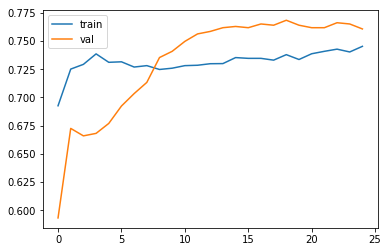

In [6]:
c +=1
relevance_f1_train, relevance_f1_val = retrain("relevance",c, iterator)


	Epoch 1: train_loss: 2.3180, train_acc: 0.2714, train_micro-f1: 0.2673 || val_loss: 0.2073, val_acc: 0.0305, val_micro-f1: 0.3109

	Epoch 2: train_loss: 2.0232, train_acc: 0.4149, train_micro-f1: 0.4109 || val_loss: 0.1878, val_acc: 0.0340, val_micro-f1: 0.3457

	Epoch 3: train_loss: 1.8418, train_acc: 0.4438, train_micro-f1: 0.4376 || val_loss: 0.1758, val_acc: 0.0390, val_micro-f1: 0.3978

	Epoch 4: train_loss: 1.7095, train_acc: 0.4749, train_micro-f1: 0.4694 || val_loss: 0.1669, val_acc: 0.0393, val_micro-f1: 0.4043

	Epoch 5: train_loss: 1.6176, train_acc: 0.4926, train_micro-f1: 0.4897 || val_loss: 0.1606, val_acc: 0.0402, val_micro-f1: 0.4130

	Epoch 6: train_loss: 1.5402, train_acc: 0.5119, train_micro-f1: 0.5054 || val_loss: 0.1559, val_acc: 0.0413, val_micro-f1: 0.4239

	Epoch 7: train_loss: 1.4940, train_acc: 0.5251, train_micro-f1: 0.5206 || val_loss: 0.1516, val_acc: 0.0428, val_micro-f1: 0.4413

	Epoch 8: train_loss: 1.4513, train_acc: 0.5341, train_micro-f1: 0.5308 || 

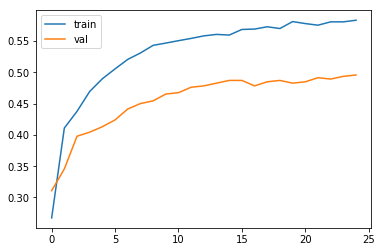

In [8]:
c +=1
attribute_f1_train, attribute_f1_val = retrain("attribute",c, iterator)


	Epoch 1: train_loss: 1.7449, train_acc: 0.3489, train_micro-f1: 0.3439 || val_loss: 0.1429, val_acc: 0.0428, val_micro-f1: 0.4435

	Epoch 2: train_loss: 1.5658, train_acc: 0.4548, train_micro-f1: 0.4500 || val_loss: 0.1333, val_acc: 0.0467, val_micro-f1: 0.4826

	Epoch 3: train_loss: 1.4460, train_acc: 0.4769, train_micro-f1: 0.4715 || val_loss: 0.1272, val_acc: 0.0478, val_micro-f1: 0.4935

	Epoch 4: train_loss: 1.3726, train_acc: 0.4903, train_micro-f1: 0.4850 || val_loss: 0.1235, val_acc: 0.0488, val_micro-f1: 0.5043

	Epoch 5: train_loss: 1.3264, train_acc: 0.5061, train_micro-f1: 0.5018 || val_loss: 0.1210, val_acc: 0.0494, val_micro-f1: 0.5087

	Epoch 6: train_loss: 1.2928, train_acc: 0.5227, train_micro-f1: 0.5161 || val_loss: 0.1191, val_acc: 0.0480, val_micro-f1: 0.4957

	Epoch 7: train_loss: 1.2817, train_acc: 0.5217, train_micro-f1: 0.5227 || val_loss: 0.1173, val_acc: 0.0499, val_micro-f1: 0.5152

	Epoch 8: train_loss: 1.2523, train_acc: 0.5341, train_micro-f1: 0.5308 || 

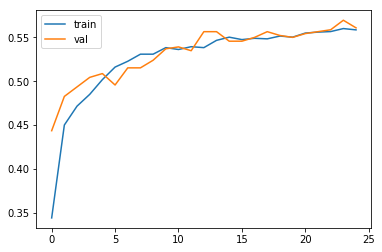

In [10]:
c +=1
entity_f1_train, entity_f1_val = retrain("entity",c, iterator)